# New Cs-137 notebook

June 2017
This removes all the acquired clutter and focusus on the PhD thesis analysis.


## Imports and settings

In [1]:
%run '../definitions.ipynb'
%run '../treemakers.ipynb'
%run '../Analysis_class.ipynb'

plt.style.use('latex_prl')
def plt_savefig(filename, folder='plots'):
    plt.savefig(os.path.join(folder, filename + '.png'), bbox_inches='tight')
    plt.savefig(os.path.join(folder, filename + '.pdf'), bbox_inches='tight')
    return
pd.options.mode.chained_assignment = None  # default='warn'


/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


In [2]:
# Toggle data location
local_data = False

In [3]:
if local_data:
    processed_data_path = '/home/erik/win/data/xams_run8/processed/low_pmt_gain/'
    minitree_path = '/home/erik/win/data/xams_run8/minitrees/'
else:
    # processed_data_path = '/data/xenon/xams/run8/processed/data/'
    # minitree_path = '/data/xenon/xams/run8/minitrees/'
    processed_data_path = '/data/xenon/xams/run8/processed_v2/'
    minitree_path = '/data/xenon/xams/run8/minitrees/'

In [4]:
run_names_cs = get_run_list(processed_data_path, '170323_152801', '170323_154257')

Run list contains 3 files


## Load data

In [5]:
x = XAMSAnalysis(run_names_cs, processed_data_path, minitree_path)

In [6]:
x.load()
x.corr_z(1.5, 1.73)

Loaded 125339 (125.3 k) events.


## Cuts

### At least one interaction

In [7]:
n_events = len(x.d)
n_events_s1 = sum((x.d['s1'] > 40) | (x.d['largest_other_s1'] > 40))

In [8]:
x.cut_interaction_exists()

Finite s1 selection: 9244 rows removed (92.62% passed)


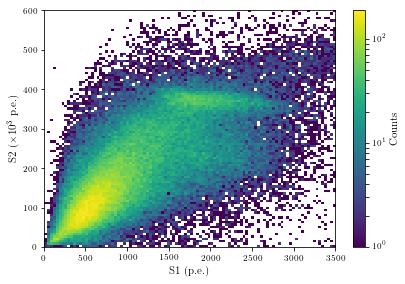

In [9]:
x.plot_s1s2(bins=100, norm=LogNorm(), range=((0, 3500), (0, 600e3)))
plt.colorbar(label='Counts')
plt_divide_axis('y', factor=1000)
plt.ylabel(r'S2 ($\times10^3$ p.e.)')
plt_savefig('cs_s1s2_uncut')

### Thresholds

Note that S2 classification is only > 8 p.e. and trigger requires some threshold as wel..

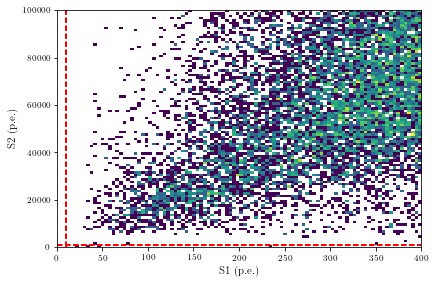

s1 above 10 selection: 0 rows removed (100.00% passed)
s2 above 1000 selection: 26 rows removed (99.98% passed)


In [10]:
x.cut_thresholds(s1_threshold=10, s2_threshold=1000,
    apply=True, plot=True, bins=100, norm=LogNorm(), range=((0, 400), (0, 100e3)))

### Single scatter S1

As shown in the figure below, a large fraction of the other S1s consist of misclassified single-e S2s or tails of the S2. We can keep these events at the risk of including true S1s that are quite small, or we throw them out. The acceptance is large anyway. 

largest_other_s1 below 40 selection: 2453 rows removed (97.89% passed)


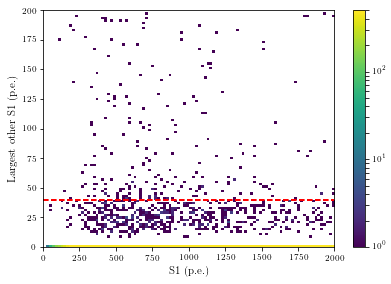

In [11]:
x.cut_largest_other_s1(largest_other_s1_max=40, plot=True, apply=True, bins=100, 
                       norm=LogNorm(), range=((0, 2000), (0, 200)), vmin=1, vmax=500)
plt.colorbar()
plt.show()

In [12]:
_hist = x.cuts_history()
acc = (1 - _hist['fraction_passed'].iloc[-1]) * 100
acc_red = (_hist['n_removed'].iloc[-1]) / _hist['n_before'].iloc[-1] * 100 # just a cross-check
assert abs(acc_red - acc) < 1e-6
dacc = np.sqrt(_hist['n_removed'].iloc[-1]) / _hist['n_before'].iloc[-1] * 100
print('S1 single scatter cut acceptance: %.3f +- %.3f' %(acc, dacc))

S1 single scatter cut acceptance: 2.113 +- 0.043


In [13]:
# Number of events actually containing something of an S1
rate  = n_events_s1 / x.livetime
rate2 = n_events / x.livetime
event_length = 163.820 * 1e-6
# This is not a great calculation, it should actually be something Poissonian
print('Estimated pileup fraction: %.2f %%' % (rate * event_length * 100))
print('Rate: %.1f Hz' % (rate))

print('Estimated pileup fraction: %.2f %%' % (rate2 * event_length * 100))
print('Rate: %.1f Hz' % (rate2))

Estimated pileup fraction: 2.24 %
Rate: 136.9 Hz
Estimated pileup fraction: 2.28 %
Rate: 139.1 Hz


### Single scatter S2

We want the second S2s to be consistent with single-electron pileup.

In [14]:
_d = x.d

In [15]:
_d = _d[(_d['largest_other_s2']) > 100]
_d['dz'] = 100 / (59.3 - 1.5) * 0.001 * abs(_d['largest_other_s2_center_time'] - _d['s2_center_time'])

In [16]:
def exp_decay(x, a0, tau):
    return a0 * np.exp(-x / tau)

In [17]:
counts, bin_edges = np.histogram(_d['dz'], bins=200, range=(0, 20))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
fit_range  = (4, 10)
x_fit = bin_centers[(bin_centers >= fit_range[0]) & (bin_centers < fit_range[1])]
y_fit = counts[(bin_centers >= fit_range[0]) & (bin_centers < fit_range[1])]
y_err = np.sqrt(y_fit)
popt_dz, pcov_dz = scipy.optimize.curve_fit(exp_decay, x_fit, y_fit, sigma = y_err, p0=[500, 10])


predicted_counts = [exp_decay(_x, *popt_dz) for _x in np.linspace(0, 10, 100)]
print('Predicted number of counts 0-10 mm: %d' % sum(predicted_counts))
actual_counts = sum(_d['dz'] < 10)
print('Actual number of counts 0-10 mm: %d' % actual_counts)

Predicted number of counts 0-10 mm: 27693
Actual number of counts 0-10 mm: 14109


In [18]:
popt_dz

array([ 609.67777675,    5.35906334])

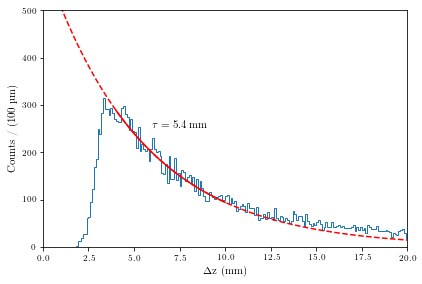

In [19]:
plt.hist(100 / (59.3 - 1.5) * 0.001 * abs(_d['largest_other_s2_center_time'] - _d['s2_center_time']), histtype='step', bins=200, 
         range=(0, 20))
x_fit_range = np.linspace(*fit_range, num = 50)
x_plot = np.linspace(0, 20, 200)
plt.plot(x_plot, exp_decay(x_plot, *popt_dz), ls='--', color='red')
plt.plot(x_fit_range, exp_decay(x_fit_range, *popt_dz), ls='solid', color='red')
plt.xlabel(r'$\Delta$z (\si{mm})')
plt.xlim(0, 20)
plt.ylabel(r'Counts / (\SI{100}{\micro m})')
plt.ylim(0, 500)
plt.text(6, 250, r'$\tau = $ \SI{5.4}{mm}')

plt_savefig('cs_s2_resolution')
plt.show()

largest_other_s2 below 100 selection: 23269 rows removed (79.52% passed)


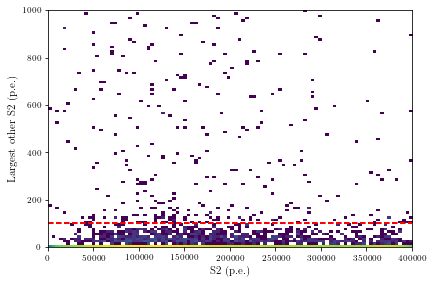

In [20]:
x.cut_largest_other_s2(largest_other_s2_max=100, 
                       plot=True, apply=True, bins=100, norm=LogNorm(), range=((0, 400e3), (0, 1000)))


This plot shows exactly what we expect for these events: a large peak at 0 from wrongly split S2s, a larger contribution after S2 and a neat spike at the cathode mesh location!

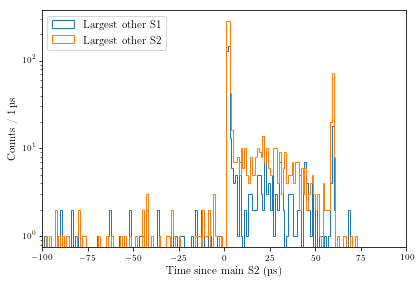

0.00555635494261
0.0120092532126


In [21]:
_d = x.d
plt.hist((_d['largest_other_s1_center_time'] - _d['s2_center_time'])*1e-3, 
         bins=200, histtype='step', range=(-100, 100), label='Largest other S1')
plt.hist((_d['largest_other_s2_center_time'] - _d['s2_center_time'])*1e-3, 
         bins=200, histtype='step', range=(-100, 100), label='Largest other S2')
plt.xlabel(r'Time since main S2 (\si{\micro s})')
plt.ylabel(r'Counts / \SI{1}{\micro s}')
plt.yscale('log')
plt.xlim(-100, 100)
plt.legend(loc='upper left')
plt_savefig('cs_other_time_diff')
plt.show()

print(sum(_d['largest_other_s1'] > 0) / len(_d))
print(sum(_d['largest_other_s2'] > 0) / len(_d))

### S2 width

In [22]:
_d = x.d

In [23]:
def s2_width_model(t, diffusion_constant, w0):
        '''
        S2 width model stolen from Jelly Monster. Great info on wiki.
        Input drift time in us
        '''
        # diffusion_constant = PAX_CONFIG['WaveformSimulator']['diffusion_constant_liquid']
        v_drift = drift_velocity_liquid = 1.73 * 10**5 # cm/s
        t = t * 1e-6 # Convert to seconds
        # w0 = 348.6 * units.ns
        # WATCH the constant: it is NOT 4.something
        return 1e9 * np.sqrt(w0 ** 2 + 3.6395 * diffusion_constant * t / v_drift ** 2)

In [24]:
for nbins in [20, 30, 40, 50]:
    dt, s2_50 = get_trend(_d['drift_time'], _d['s2_range_50p_area'], (0, 60), bins=nbins, mode='median')
    dt_cutoff = 30 # us

    popt_s2_w, pcov_s2_w = scipy.optimize.curve_fit(s2_width_model, dt[dt >= dt_cutoff], s2_50[dt > dt_cutoff],
                                                    p0=[10, 250e-9])
    perr_s2_w = np.sqrt(np.diag(pcov_s2_w))
    print('Diffusion is %.2f +- %.2f cm**2 / s' % (popt_s2_w[0], perr_s2_w[0]))


Diffusion is 15.47 +- 0.34 cm**2 / s
Diffusion is 15.48 +- 0.41 cm**2 / s
Diffusion is 15.58 +- 0.31 cm**2 / s
Diffusion is 15.60 +- 0.37 cm**2 / s


In [25]:
for cutoff in [20, 25, 30, 35, 40]:
    nbins = 30
    dt_cutoff = cutoff 
    dt, s2_50 = get_trend(_d['drift_time'], _d['s2_range_50p_area'], (0, 60), bins=nbins, mode='median')

    popt_s2_w, pcov_s2_w = scipy.optimize.curve_fit(s2_width_model, dt[dt >= dt_cutoff], s2_50[dt >= dt_cutoff],
                                                    p0=[10, 250e-9])
    perr_s2_w = np.sqrt(np.diag(pcov_s2_w))
    print('Diffusion is %.2f +- %.2f cm**2 / s' % (popt_s2_w[0], perr_s2_w[0]))


Diffusion is 15.04 +- 0.32 cm**2 / s
Diffusion is 14.98 +- 0.33 cm**2 / s
Diffusion is 15.48 +- 0.41 cm**2 / s
Diffusion is 15.65 +- 0.54 cm**2 / s
Diffusion is 16.29 +- 0.89 cm**2 / s


In [26]:
# The Final Solution (too soon?)
nbins = 30
dt_cutoff = 30
syst_err = np.sqrt(0.1**2 + 0.4**2)

dt, s2_50 = get_trend(_d['drift_time'], _d['s2_range_50p_area'], (0, 60), bins=nbins, mode='median')

popt_s2_w, pcov_s2_w = scipy.optimize.curve_fit(s2_width_model, dt[dt >= dt_cutoff], s2_50[dt >= dt_cutoff],
                                                p0=[10, 250e-9])
perr_s2_w = np.sqrt(np.diag(pcov_s2_w))
print('Diffusion is %.2f +- %.2f +- %.2f cm**2 / s' % (popt_s2_w[0], perr_s2_w[0], syst_err))
total_err = np.sqrt(perr_s2_w[0]**2 + syst_err**2)
print('Diffusion is %.2f +- %.2f cm**2 / s' % (popt_s2_w[0], total_err))

pickle.dump((popt_s2_w, pcov_s2_w), open('data/cs137_s2_width.pickle', 'wb'))

Diffusion is 15.48 +- 0.41 +- 0.41 cm**2 / s
Diffusion is 15.48 +- 0.58 cm**2 / s


In [27]:
_d['s2_width_difference'] = _d['s2_range_50p_area'] - s2_width_model(_d['drift_time'], *popt_s2_w)

Cutoff at 251.5 ns


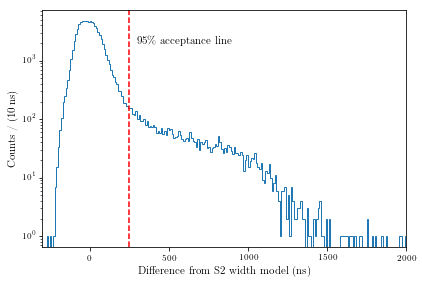

In [28]:
plt.hist(_d['s2_width_difference'], bins=230, histtype='step', range=(-300, 2000))
percentile_to_cut = 95
cutoff = np.percentile(_d['s2_width_difference'], percentile_to_cut)
print('Cutoff at %.1f ns' % cutoff)
plt.text(cutoff + 50, 2e3, (r'95\% acceptance line'))
plt.axvline(cutoff, ls='--', color='red')
plt.yscale('log')
plt.xlabel(r'Difference from S2 width model (\si{\nano s})')
plt.ylabel(r'Counts / (\SI{10}{ns})')
plt.xlim(-300, 2000)
plt_savefig('cs_s2_width_hist')
plt.show()

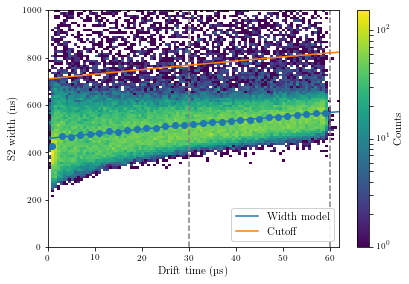

In [29]:
plt.hist2d(_d['drift_time'], _d['s2_range_50p_area'], bins=100, range=((0, 62), (0, 1e3)), norm=LogNorm())
plt.colorbar(label='Counts')
plt.xlabel(r'Drift time (\si{\micro s})')
plt.ylabel(r'S2 width (\si{\nano s})')
x_plot = np.linspace(0, 62, 100)
p0 = [10, 250e-9]
plt.plot(x_plot, s2_width_model(x_plot, *popt_s2_w), label='Width model')
plt.plot(x_plot, s2_width_model(x_plot, *popt_s2_w) + cutoff, label='Cutoff')
for _l in (30, 60):
    plt.axvline(_l, ls='--', color='gray')
plt.scatter(dt, s2_50)
plt.legend(framealpha=0.9, loc = 'lower right')
plt_savefig('cs_s2_width')
plt.show()

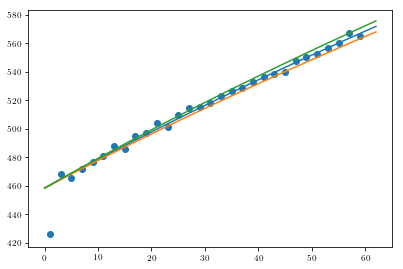

In [30]:
plt.plot(x_plot, s2_width_model(x_plot, *popt_s2_w), label='Width model')
for _pm in [-1, +1]:
    plt.plot(x_plot, s2_width_model(x_plot, popt_s2_w[0] + _pm * total_err, popt_s2_w[1]), label='+- 1 sigma')
plt.scatter(dt, s2_50, label='Medians')
plt.show()

#### Calculate resolution, contamination, and apply cut

In [31]:
# This is how many mm the 250 ns cutoff would correspond to in drift time
cutoff / ((59.3-1.5)* 1e3) * 100 # mm
# Estimate factor of 2 difference? 1500 ns width versus 3 us cutoff (5 mm)

0.43516014918484369

In [32]:
_d = cuts.selection(_d, _d['s2_width_difference'] < cutoff, 'S2 width')

S2 width selection: 4518 rows removed (95.00% passed)


In [33]:
# Predicted counts 0-10 mm minus observed 0-10 mm minus number of rows cut
n_counts_left = sum(predicted_counts) - actual_counts - 4518

In [34]:
n_counts_left

9066.7866830130115

In [35]:
a0  = popt_dz[0]
tau = popt_dz[1]
bin_width = 0.1
a0*tau*(1 - np.exp(- 10./tau)) / bin_width

27617.138443224965

In [36]:
# ACTUAL ESTIMATED RESOLVING POWER S2S in mm
- tau * np.log(1 - n_counts_left * 0.1/(a0 * tau))

1.7419039509604999

In [37]:
# Apply cut by re-inserting the dataframe
x.d = _d

### Drift time

drift_time in [0, 62) selection: 3 rows removed (100.00% passed)


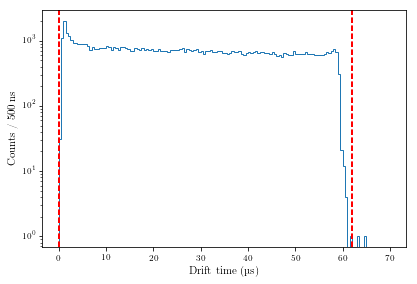

In [38]:
x.cut_drift_time(apply=True, plot=True, range=(0, 70), drift_time_bounds=(0, 62), bins=140, histtype='step')
plt.yscale('log')
plt.xlabel(r'Drift time (\si{\micro s})')
plt.ylabel(r'Counts / \SI{500}{\nano s}')

## Cut summary

In [39]:
asdf = x.cuts_history()

In [40]:
asdf['n_removed'] / asdf['n_before'] * 100

0     7.375198
1     0.000000
2     0.022395
3     2.113398
4    20.480390
5     5.000719
6     0.003495
dtype: float64

In [41]:
asdf

,selection_desc,n_before,n_after,n_removed,fraction_passed,cumulative_fraction_left
0,Finite s1,125339,116095,9244,0.926248,0.926248
1,s1 above 10,116095,116095,0,1.000000,0.926248
2,s2 above 1000,116095,116069,26,0.999776,0.926041
3,largest_other_s1 below 40,116069,113616,2453,0.978866,0.906470
4,largest_other_s2 below 100,113616,90347,23269,0.795196,0.720821
5,S2 width,90347,85829,4518,0.949993,0.684775
6,"drift_time in [0, 62)",85829,85826,3,0.999965,0.684751


In [42]:
n_counts_left / 85826

0.10564149189072089

## Position calibration

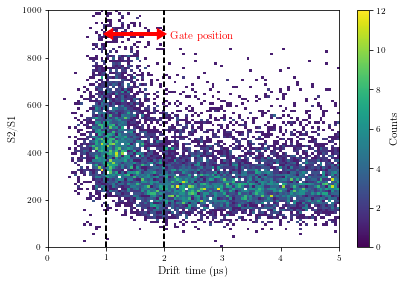

In [43]:
plt.hist2d(x.d['drift_time'], x.d['s2'] / x.d['s1'], bins=100, range=((0, 5), (0, 1000)), vmin=(0.00001))
cbar = plt.colorbar(label='Counts')
# Godverdomme hoe moeilijk kan het zijn in focking hemelsnaam dit geloof je niet
cbar.set_ticks([0.00001,2,4,6,8,10,12])
cbar.set_ticklabels([0,2,4,6,8,10,12])
bounds = (1,2)
for _l in bounds:
    plt.axvline(_l, color='black'
                , zorder=1, lw=2, ls='--') 

arrow_y = 900
for _x, _dx in zip((1, 2), (1, -1)):
    plt.arrow(_x, arrow_y, _dx, 0, color='red', head_length = 0.1,
      head_width = 30, length_includes_head = True , zorder=2, lw=3)

plt.text(2+0.1, 900 - 20, 'Gate position', color='red')
plt.xlabel('Drift time (\si{\micro s})')
plt.ylabel('S2/S1')
plt_savefig('dt_gate')
plt.show()

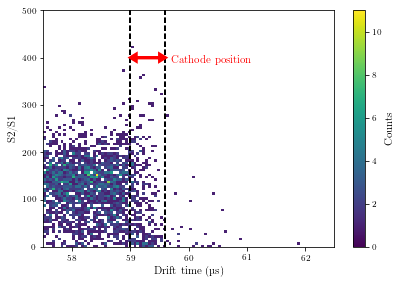

In [44]:
plt.hist2d(x.d['drift_time'], x.d['s2'] / x.d['s1'], bins=100, range=((57.5, 62.5), (0, 500)), vmin=0.00001)
cbar = plt.colorbar(label='Counts')
cbar.set_ticks([0.00001,2,4,6,8,10,12])
cbar.set_ticklabels([0,2,4,6,8,10,12])
bounds = (59, 59.6)
for _l in bounds:
    plt.axvline(_l, color='black'
                , zorder=1, lw=2, ls='--') 

arrow_y = 400
for _x, _dx in zip((59, 59.6), (0.6, -0.6)):
    plt.arrow(_x, arrow_y, _dx, 0, color='red', head_length = 0.1,
      head_width = 15, length_includes_head = True , zorder=2, lw=3)

plt.text(59.6+0.1, 400 - 10, 'Cathode position', color='red')
plt.xlabel('Drift time (\si{\micro s})')
plt.ylabel('S2/S1')
plt_savefig('dt_cathode')
plt.show()

In [45]:
delta_z = 0.100
delta_t = (59.3 - 1.5) * 1e-6

ddelta_z = 0.0005 # 1 mm precision is probably OK
ddelta_t = np.sqrt(0.5**2 + 0.3**2) * 1e-6

drift_vel = delta_z / delta_t
ddrift_vel = np.sqrt((ddelta_z/delta_z)**2 +(ddelta_t/delta_t)**2 ) * drift_vel
print('Drift vel. : %.1f +- %.1f m/s' % (drift_vel, ddrift_vel))

Drift vel. : 1730.1 +- 19.5 m/s


## Corrections

### Compute S1 LY correction based on rough selection

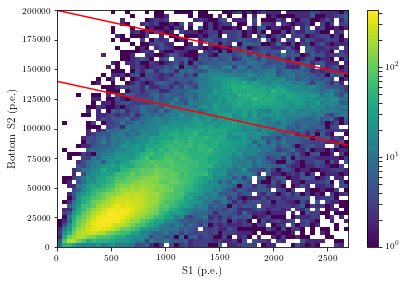

In [46]:
x.plot_s1bs2(bins=60, norm=LogNorm(), range=((0, 2700), (0, 200e3)))
x_plot = np.linspace(0, 3e3, 10)
def lower(s1):
    return 140e3 - 20*s1
def upper(s1):
    return 200e3 - 20 * s1

plt.plot(x_plot, upper(x_plot), color='red')
plt.plot(x_plot, lower(x_plot), color='red')
plt.colorbar()
plt.show()

In [47]:
d = x.d
# Select photopeak
d = d[(d['s2_bot'] < upper(d['s1'])) & (d['s2_bot'] > lower(d['s1']))]

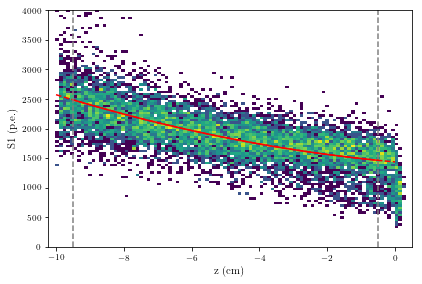

In [48]:
sel = (d['z'] < - 0.5) & (d['z'] > - 9.5)
popt, pcov = scipy.optimize.curve_fit(p2, d['z'][sel], d['s1'][sel], p0=[500, 1, 10])

pickle.dump((popt, pcov), open('data/cs137_ly_p2_rough.pickle', 'wb'))

plt.hist2d(d['z'], d['s1'], bins=100, norm=LogNorm(), range=((-10.25,0.5), (0,4000)))
x_plot = np.linspace(-10,0, 250)
x_fit_range = np.linspace(-9.5, -0.5, 200)
plt.plot(x_fit_range, p2(x_fit_range, *popt), label='Quadratic fit', color='red')
plt.plot(x_plot, p2(x_plot, *popt), label='Quadratic fit', color='red', ls='--')
for _l in (-9.5, -0.5):
    plt.axvline(_l, ls='--', color='gray')


plt.xlabel(r'z (\si{cm})')
plt.ylabel('S1 (p.e.)')
# plt.legend(loc='lower left')
plt.show()

### Compute S2 correction

In [49]:
d = x.d
# Select photopeak
d = d[(d['s2_bot'] < upper(d['s1'])) & (d['s2_bot'] > lower(d['s1']))]

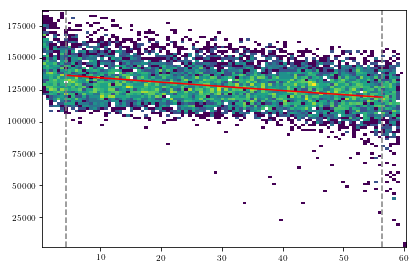

In [50]:
bounds_z = (-9.5, -0.5)
def z_to_dt(z):
    return (-z / 10) * (59.3 - 1.5) + 1.5
bounds_dt = [z_to_dt(bounds_z[i]) for i in (1,0)]
sel = (d['drift_time'] > bounds_dt[0]) & (d['drift_time'] < bounds_dt[1])
popt_s2_life, pcov_s2_life = scipy.optimize.curve_fit(exp_decay, d['drift_time'], d['s2_bot'], p0 = [125e3, 400])
x_plot = np.linspace(*bounds_dt,num=200)
plt.plot(x_plot, exp_decay(x_plot, *popt_s2_life), color='red')
for _l in bounds_dt:
    plt.axvline(_l, ls='--', color='gray')
plt.hist2d(d['drift_time'], d['s2_bot'], bins=100, norm=LogNorm())
pickle.dump((popt_s2_life, pcov_s2_life), open('data/cs137_electron_lifetime_rough.pickle', 'wb'))
plt.show()

### Apply corrections

In [51]:
popt_s2_life

array([ 137914.42203883,     385.76371214])

In [52]:
x.corr_s1_ly_poly('data/cs137_ly_p2_rough.pickle')
x.corr_s2_electron_lifetime(pickle_file='data/cs137_electron_lifetime_rough.pickle', verbose=True)

Using lifetime 385.763712


## Fit

### Photopeak selection

In [53]:
cs1_range = (1400, 2500)
cs2_range = (110e3, 170e3)
cs1_bins = 40
cs2_bins = 40

In [54]:
def cut1(x):
    return 190e3 - 40*x   
def cut2(x):
    return 240e3 - 40*x  

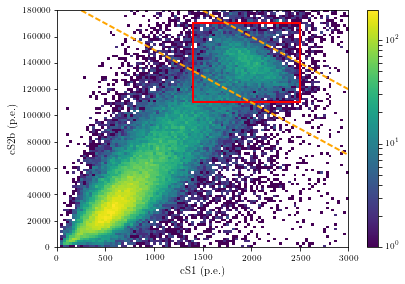

In [55]:
x.plot_cs1cs2b(bins=100, norm=LogNorm(), range=((0, 3000), (0, 180e3)))
plt.colorbar()
draw_box(cs1_range, cs2_range, edgecolor='red', lw=2)
x_plot = np.linspace(0, 3000, 20)
plt.plot(x_plot, cut1(x_plot), color='orange', lw=2, ls='--')
plt.plot(x_plot, cut2(x_plot), color='orange', lw=2, ls='--')

### Binned fit

In [56]:
d = x.d

In [57]:
counts, x_fit, y_fit = build_fit_lists(d['cs1'], d['cs2b'], cs1_range, cs2_range, cs1_bins, cs2_bins)

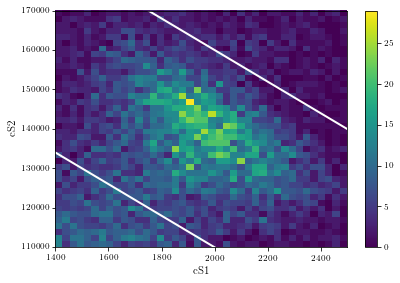

In [58]:
plt.hist2d(d['cs1'], d['cs2b'], bins=(cs1_bins, cs2_bins), range=(cs1_range, cs2_range))#, norm=LogNorm())

x_plot = np.linspace(*cs1_range, num=20)
for cut in [cut1, cut2]:
    plt.plot(x_plot, cut(x_plot), color='white', lw=2)
plt.colorbar()
plt.xlabel('cS1')
plt.ylabel('cS2')
plt.show()

In [59]:
sel = (cut1(x_fit) < y_fit) & (cut2(x_fit) > y_fit)

In [60]:
initial_guess = (30,2000,130000,30,2000,-0.03,0)
popt, pcov = scipy.optimize.curve_fit(twoD_Gaussian, (x_fit[sel], y_fit[sel]), counts[sel], p0=initial_guess)
print('cS1 peak position: %.1f' % (popt[1]))
print('cS2 peak position: %.1f' % (popt[2]))
print(popt)
theta = popt[-2]
slope = np.tan(theta)

cS1 peak position: 1955.5
cS2 peak position: 138712.0
[  1.67796687e+01   1.95545696e+03   1.38712013e+05  -1.93483917e+02
  -1.19014549e+04  -7.62991825e-03   1.81113323e+00]


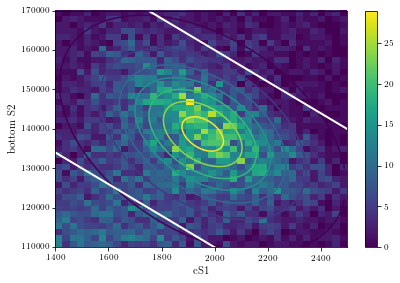

In [61]:
plt.hist2d(d['cs1'], d['cs2b'], bins=(cs1_bins, cs2_bins), range=(cs1_range, cs2_range))#, norm=LogNorm())

x_plot = np.linspace(*cs1_range, num=20)
for cut in [cut1, cut2]:
    plt.plot(x_plot, cut(x_plot), color='white', lw=2)
plt.colorbar()

plot2d(twoD_Gaussian, popt, cs1_range, cs2_range, 10, 100)

plt.xlabel('cS1')
plt.ylabel('bottom S2')
# plt.savefig('plots/cs_photopeak_fit.png')
plt.show()

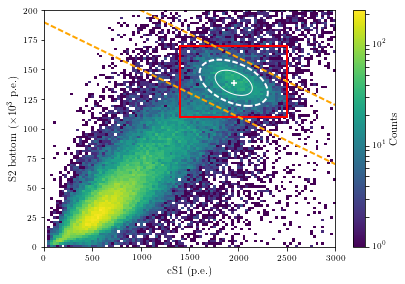

In [62]:
x.plot_cs1cs2b(bins=100, norm=LogNorm(), range=((0, 3000), (0, 200e3)))
plt.colorbar(label='Counts')
draw_box(cs1_range, cs2_range, edgecolor='red', lw=2)
x_plot = np.linspace(0, 3000, 20)
plt.plot(x_plot, cut1(x_plot), color='orange', lw=2, ls='--')
plt.plot(x_plot, cut2(x_plot), color='orange', lw=2, ls='--')
# Draw contours at 0.5, 1 and 1.5 sigma
gaus_max = popt[0]
sigma_levels = [gaus(1.5, gaus_max, 0, 1), gaus(1, gaus_max, 0, 1), gaus(0.5, gaus_max, 0, 1)]
plot2d(twoD_Gaussian, popt, (1400, 2600), cs2_range, 4, 40, levels=sigma_levels, 
       colors=['white', 'white', 'white'],
       linewidths = [2,2,1],
       linestyles = ['solid', 'dashed', 'solid'],
      )
plt_divide_axis('y', 1000)
plt.ylabel(r'S2 bottom ($\times 10^3$ p.e.)')
plt.scatter(popt[1], popt[2], marker = '+', color='white')

In [63]:
pickle.dump((popt, pcov), open('data/cs137_s1s2fit_2d_rough.pickle', 'wb'))

## Second selection of photopeak

In [64]:
iteration_number = 2
# Load cs1 and cs2 from previous calibration
if iteration_number == 0:
    x.corr_s1_ly_poly(ly_filename='data/cs137_ly_p2_rough.pickle')
    x.corr_s2_electron_lifetime(pickle_file='data/cs137_electron_lifetime_rough.pickle')
    x.add_g1g2_props(pickle_file='data/doke_rough.pickle')
else:
    x.corr_s1_ly_poly(ly_filename='data/cs137_ly_p2_sel%d.pickle' % (iteration_number - 1))
    x.corr_s2_electron_lifetime(pickle_file='data/cs137_electron_lifetime_sel%d.pickle' % (iteration_number - 1), 
                                verbose  =True)
    x.add_g1g2_props(pickle_file='data/doke_sel%d.pickle' % (iteration_number - 1))

Using lifetime 805.241413


#### Fit photopeak in CES

-775.432061877


/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: errordef is not given. Default to 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter a0 is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter off is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter slope is floating but does not 

FCN = -937.2638689614693 
 TOTAL NCALL = 138 
 NCALLS = 138 
 
 
 EDM = 852.9403581178093 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a0,220.601,6.16867,0,0,,,
2,mu,663.139,35.7322,0,0,,,
3,sigma,37.0394,20.2582,0,0,,,
4,off,287.269,41.3833,0,0,,,
5,slope,-0.331083,0.12519,0,0,,,


0.05585468407180831


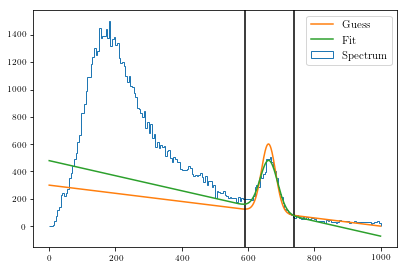

In [65]:
# Fit to photopeak
popt_ces, m_ces, norm = fit_gaus_with_bg(x.d['e_ces'].values, (590, 740), 500, 662,  30, 300, -0.3)

### Get the new S1 correction!

In [66]:
sigmas_to_select = 1.5

energy_range = (m_ces.values['mu'] - sigmas_to_select * m_ces.values['sigma'], 
                m_ces.values['mu'] + sigmas_to_select * m_ces.values['sigma'])
d = x.d
pp = cuts.range_selection(d, 'e_ces', energy_range)
print(len(pp))

e_ces in [607.5801448063929, 718.6984529060359) selection: 78688 rows removed (8.32% passed)
7138


In [67]:
#photopeak S1 selection
sigmas_to_select_cs1 = 2.5

popt_cs1_it0, _ , _ =  fit_gaus(pp['cs1'], (1200, 2500), 2000, 200, (0, 3000), 300, plot=False, print_level=0)
pp = cuts.range_selection(pp, 'cs1', (popt_cs1_it0[0] - sigmas_to_select_cs1 * popt_cs1_it0[1], 
                                             popt_cs1_it0[0] + sigmas_to_select_cs1 * popt_cs1_it0[1]))

cs1 in [1102.8361400845451, 2803.8053344282484) selection: 114 rows removed (98.40% passed)


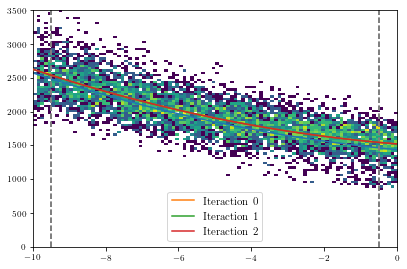

In [68]:
plt.hist2d(pp['z'], pp['s1'], bins=100, range=((-10, 0), (0, 3500)), norm=LogNorm())
fit_range = (-9.5, -0.5)

# Load previous LY calibration curve
popt_s1_ly_rough, pcov_s1_ly_rough = pickle.load(open('data/cs137_ly_p2_rough.pickle', 'rb'))
sel = (pp['z'] >= fit_range[0]) & (pp['z'] < fit_range[1])
popt_s1_ly_sel0, pcov_s1_ly_sel0 = scipy.optimize.curve_fit(p2, pp['z'][sel], pp['s1'][sel], p0=[500, 1, 10])

pickle.dump((popt_s1_ly_sel0, pcov_s1_ly_sel0), open('data/cs137_ly_p2_sel%d.pickle' % iteration_number, 'wb'))

x_plot = np.linspace(-10, 0, 200)
# plt.plot(x_plot, p2(x_plot, *popt_s1_ly_sel0), color='red')
plt.plot(x_plot, p2(x_plot, *popt_s1_ly_rough))

for _i in range(iteration_number + 1):
    _popt, _ = pickle.load(open('data/cs137_ly_p2_sel%d.pickle' % iteration_number, 'rb'))
    plt.plot(x_plot, p2(x_plot, *_popt), label='Iteraction %d' % _i, zorder = 5)

for _l in fit_range:
    plt.axvline(_l, color='gray', ls='--', lw=2)
plt.legend()
plt.show()

### Get the new S2 correction!

e_ces in [607.5801448063929, 718.6984529060359) selection: 78688 rows removed (8.32% passed)
s2_bot in [87670.5226883923, 170100.16326745466) selection: 181 rows removed (97.46% passed)
Lifetime: 810.7 +- 43.3 us


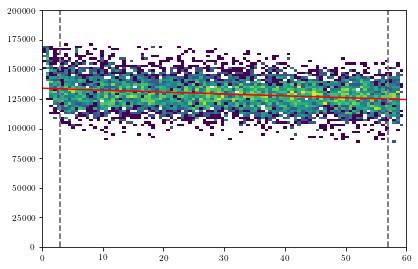

In [69]:
# Select in CES space
sigmas_to_select = 1.5
sigmas_to_select_cs2 = 2.5

energy_range = (m_ces.values['mu'] - sigmas_to_select * m_ces.values['sigma'], 
                m_ces.values['mu'] + sigmas_to_select * m_ces.values['sigma'])
d = x.d
pp = cuts.range_selection(d, 'e_ces', energy_range)

# Refine selection in s2 bot
popt_cs2_it0, _ , _ =  fit_gaus(pp['s2_bot'],  (100e3, 160e3), 120e3, 20e3, (0, 250e3), 300, int_step=10
                                , plot=False, print_level=0)
pp = cuts.range_selection(pp, 's2_bot', (popt_cs2_it0[0] - sigmas_to_select_cs2 * popt_cs2_it0[1], 
                                             popt_cs2_it0[0] + sigmas_to_select_cs2 * popt_cs2_it0[1]))

plt.hist2d(pp['drift_time'], pp['s2_bot'], bins=100, range=((0, 60), (0, 200e3)), norm=LogNorm())

fit_range = np.array((0.5, 9.5)) * 60 / 10
sel = (pp['drift_time'] >= fit_range[0]) & (pp['drift_time'] < fit_range[1])

popt_s2_life, pcov_s2_life = scipy.optimize.curve_fit(exp_decay, pp['drift_time'], pp['s2_bot'], p0 = [125e3, 200])
x_plot = np.linspace(0, 60, 100)
plt.plot(x_plot, exp_decay(x_plot, *popt_s2_life), color='red')
print('Lifetime: %.1f +- %.1f us' % (popt_s2_life[1], np.sqrt(np.diag(pcov_s2_life))[1]))
pickle.dump((popt_s2_life, pcov_s2_life), open('data/cs137_electron_lifetime_sel%d.pickle' % iteration_number, 'wb'))
for _l in fit_range:
    plt.axvline(_l, color='gray', ls='--', lw=2)
plt.show()

### Apply those new corrections

In [70]:
x.corr_s1_ly_poly(ly_filename='data/cs137_ly_p2_sel%d.pickle' % iteration_number)
x.corr_s2_electron_lifetime(pickle_file='data/cs137_electron_lifetime_sel%d.pickle' % iteration_number, verbose=True)

Using lifetime 810.658412


#### Fit S1

e_ces in [626.0998628230001, 700.1787348894287) selection: 80145 rows removed (6.62% passed)
[1970.551746584021, 308.39285765466394]
e_ces in [626.0998628230001, 700.1787348894287) selection: 80145 rows removed (6.62% passed)
[1968.5117953486879, 307.44889079143474]
e_ces in [626.0998628230001, 700.1787348894287) selection: 80145 rows removed (6.62% passed)
[1964.5102739149302, 316.06731457769774]
e_ces in [607.5801448063929, 718.6984529060359) selection: 78688 rows removed (8.32% passed)
[1959.3348409804637, 320.8011212487649]
e_ces in [607.5801448063929, 718.6984529060359) selection: 78688 rows removed (8.32% passed)
[1959.481630698237, 323.36134166182376]
e_ces in [607.5801448063929, 718.6984529060359) selection: 78688 rows removed (8.32% passed)
[1955.8508292776141, 334.79104279496937]
e_ces in [589.0604267897858, 737.218170922643) selection: 77610 rows removed (9.57% passed)
[1943.628517132209, 332.6903375439089]
e_ces in [589.0604267897858, 737.218170922643) selection: 77610 rows

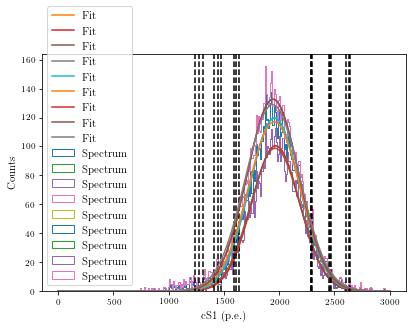

In [71]:
popts = []

# Scan different peak selections
for sigmas_to_select in [1.0, 1.5, 2.0]:
    for sigmas_to_select_cs1 in [1.0, 1.5, 2.0]:
    
        # re-select energies
        energy_range = (m_ces.values['mu'] - sigmas_to_select * m_ces.values['sigma'], 
                        m_ces.values['mu'] + sigmas_to_select * m_ces.values['sigma'])
        d = x.d
        pp = cuts.range_selection(d, 'e_ces', energy_range)

        popt_cs1_it0, _ , _ =  fit_gaus(pp['cs1'], (1200, 2500), 2000, 200, (0, 3000), 300, plot=False, print_level=0)
        popt_cs1_it1, m_cs1_it1 , _ =  fit_gaus(pp['cs1'], (popt_cs1_it0[0] - sigmas_to_select_cs1 * popt_cs1_it0[1], 
                                             popt_cs1_it0[0] + sigmas_to_select_cs1 * popt_cs1_it0[1])
                                 , popt_cs1_it0[0], popt_cs1_it0[1], (0, 3000), 300, print_level = 0, plot_guess=False)
        plt.xlabel('cS1 (p.e.)')
        plt.ylabel('Counts')
        print(popt_cs1_it1)
        popts.append([sigmas_to_select, sigmas_to_select_cs1] + popt_cs1_it1)

e_ces in [607.5801448063929, 718.6984529060359) selection: 78688 rows removed (8.32% passed)
[1959.481630698237, 323.36134166182376]


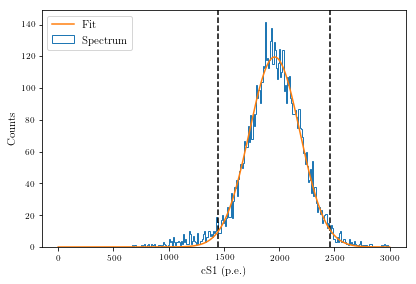

In [72]:
sigmas_to_select = 1.5
sigmas_to_select_cs1 = 1.5
    
# re-select energies
energy_range = (m_ces.values['mu'] - sigmas_to_select * m_ces.values['sigma'], 
                m_ces.values['mu'] + sigmas_to_select * m_ces.values['sigma'])
d = x.d
pp = cuts.range_selection(d, 'e_ces', energy_range)

popt_cs1_it0, _ , _ =  fit_gaus(pp['cs1'], (1200, 2500), 2000, 200, (0, 3000), 300, plot=False, print_level=0)
popt_cs1_it1, m_cs1_it1 , _ =  fit_gaus(pp['cs1'], (popt_cs1_it0[0] - sigmas_to_select_cs1 * popt_cs1_it0[1], 
                                     popt_cs1_it0[0] + sigmas_to_select_cs1 * popt_cs1_it0[1])
                         , popt_cs1_it0[0], popt_cs1_it0[1], (0, 3000), 300, print_level = 0, plot_guess=False)
plt.xlabel('cS1 (p.e.)')
plt.ylabel('Counts')
print(popt_cs1_it1)


In [73]:
popt_s1 = m_cs1_it1.values
perr_s1 = m_cs1_it1.errors
perr_s1_syst = np.std(np.array(popts)[:,2])

In [74]:
print((popt_s1, perr_s1, perr_s1_syst))

({'sigma': 323.36134166182376, 'mu': 1959.481630698237}, {'sigma': 5.401402540111828, 'mu': 4.291885412392135}, 10.204958613403049)


In [75]:
pickle.dump((popt_s1, perr_s1, perr_s1_syst), open('data/cs137_s1_sel%d.pickle' % iteration_number, 'wb'))

### ... And for S2

e_ces in [626.0998628230001, 700.1787348894287) selection: 80145 rows removed (6.62% passed)
[133833.67579578902, 15298.774092817852]
e_ces in [626.0998628230001, 700.1787348894287) selection: 80145 rows removed (6.62% passed)
[134005.5772439018, 15943.508858546022]
e_ces in [626.0998628230001, 700.1787348894287) selection: 80145 rows removed (6.62% passed)
[134201.65827564988, 16150.815467910707]
e_ces in [607.5801448063929, 718.6984529060359) selection: 78688 rows removed (8.32% passed)
[133231.3515372395, 15943.14796047736]
e_ces in [607.5801448063929, 718.6984529060359) selection: 78688 rows removed (8.32% passed)
[133622.8947756198, 16635.476934723745]
e_ces in [607.5801448063929, 718.6984529060359) selection: 78688 rows removed (8.32% passed)
[133948.43543056946, 17004.33035882258]
e_ces in [589.0604267897858, 737.218170922643) selection: 77610 rows removed (9.57% passed)
[132648.79238971634, 17057.233942533214]
e_ces in [589.0604267897858, 737.218170922643) selection: 77610 rows

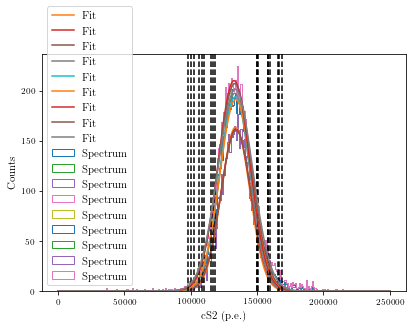

In [76]:
popts = []

# Scan different peak selections
for sigmas_to_select in [1.0, 1.5, 2.0]:
    for sigmas_to_select_cs2 in [1.0, 1.5, 2.0]:   
        # re-select energies
        energy_range = (m_ces.values['mu'] - sigmas_to_select * m_ces.values['sigma'], 
                        m_ces.values['mu'] + sigmas_to_select * m_ces.values['sigma'])
        d = x.d
        pp = cuts.range_selection(d, 'e_ces', energy_range)

        popt_cs2_it0, _ , _ =  fit_gaus(pp['cs2b'],  (100e3, 160e3), 120e3, 20e3, (0, 250e3), 300, int_step=10
                                        , plot=False, print_level=0)
        popt_cs2_it1, m_cs2_it1 , _ =  fit_gaus(pp['cs2b'], (popt_cs2_it0[0] - sigmas_to_select_cs2 * popt_cs2_it0[1], 
                                             popt_cs2_it0[0] + sigmas_to_select_cs2 * popt_cs2_it0[1])
                                 , popt_cs2_it0[0], popt_cs2_it0[1], 
                                                (0, 250e3), 300, int_step=10, print_level = 0, plot_guess=False)
        plt.xlabel('cS2 (p.e.)')
        plt.ylabel('Counts')
        print(popt_cs2_it1)
        popts.append([sigmas_to_select, sigmas_to_select_cs2] + popt_cs2_it1)

e_ces in [607.5801448063929, 718.6984529060359) selection: 78688 rows removed (8.32% passed)


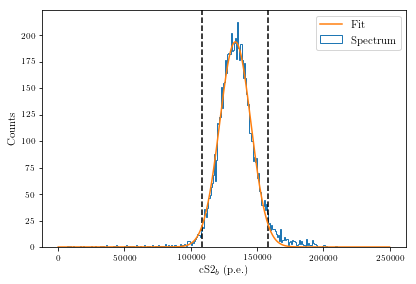

In [77]:
sigmas_to_select = 1.5
sigmas_to_select_cs2 =1.5
# re-select energies
energy_range = (m_ces.values['mu'] - sigmas_to_select * m_ces.values['sigma'], 
                m_ces.values['mu'] + sigmas_to_select * m_ces.values['sigma'])
d = x.d
pp = cuts.range_selection(d, 'e_ces', energy_range)

popt_cs2_it0, _ , _ =  fit_gaus(pp['cs2b'],  (100e3, 160e3), 120e3, 20e3, (0, 250e3), 300, int_step=10
                                , plot=False, print_level=0)
popt_cs2_it1, m_cs2_it1 , _ =  fit_gaus(pp['cs2b'], (popt_cs2_it0[0] - sigmas_to_select_cs2 * popt_cs2_it0[1], 
                                     popt_cs2_it0[0] + sigmas_to_select_cs2 * popt_cs2_it0[1])
                         , popt_cs2_it0[0], popt_cs2_it0[1], 
                                        (0, 250e3), 300, int_step=10, print_level = 0, plot_guess=False)
plt.xlabel('cS2$_b$ (p.e.)')
plt.ylabel('Counts')


In [78]:
popt_s2 = m_cs2_it1.values
perr_s2 = m_cs2_it1.errors
perr_s2_syst = np.std(np.array(popts)[:,2])

In [79]:
print((popt_s2, perr_s2, perr_s2_syst))

({'sigma': 16635.476934723745, 'mu': 133622.8947756198}, {'sigma': 297.22356395357275, 'mu': 226.5021060686454}, 459.65792016431283)


In [80]:
pickle.dump((popt_s2, perr_s2, perr_s2_syst), open('data/cs137_s2_sel%d.pickle' % iteration_number, 'wb'))

In [81]:
iteration_number

2

### Nice figures

In [82]:
x.corr_s1_ly_poly(ly_filename='data/cs137_ly_p2_sel2.pickle')
x.corr_s2_electron_lifetime(pickle_file='data/cs137_electron_lifetime_sel2.pickle', 
                                verbose  =True)
x.add_g1g2_props(pickle_file='data/doke_sel2.pickle')

Using lifetime 810.658412


-874.20730113


/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: errordef is not given. Default to 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter a0 is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter off is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter slope is floating but does not 

FCN = -977.6508625003404 
 TOTAL NCALL = 177 
 NCALLS = 177 
 
 
 EDM = 5.448879509207065e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a0,140.699,22.5653,0,0,,,
2,mu,666.283,0.959061,0,0,,,
3,sigma,33.3987,1.54388,0,0,,,
4,off,284.549,34.6368,0,0,,,
5,slope,-0.350404,0.0426786,0,0,,,


0.050126910334304574


(0, 1200)

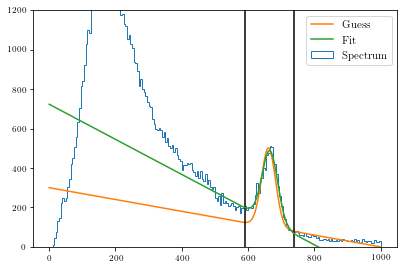

In [83]:
popt_ces, m_ces, norm = fit_gaus_with_bg(x.d['e_ces'].values, (590, 740), 400, 662,  30, 300, -0.3)
plt.ylim(0, 1200)

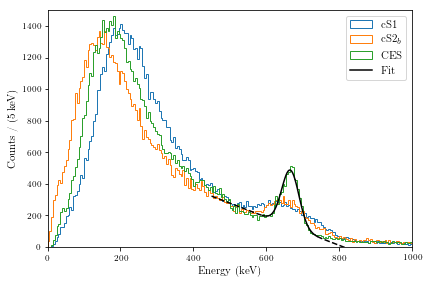

In [84]:


popt_cs_s1_sel2, perr_cs_s1_sel2, perr_syst_cs_s1_sel2 = pickle.load(open('data/cs137_s1_sel2.pickle', 'rb'))
popt_cs_s2_sel2, perr_cs_s2_sel2, perr_syst_cs_s2_sel2 = pickle.load(open('data/cs137_s2_sel2.pickle', 'rb'))


avg_cs1 = popt_cs_s1_sel2['mu']
plt.hist(x.d['cs1'] * 662 / avg_cs1 , bins=200, range=(0, 1e3), histtype='step', label='cS1')

avg_cs2b = popt_cs_s2_sel2['mu']
plt.hist(x.d['cs2b'] * 662 / avg_cs2b , bins=200, range=(0, 1e3), histtype='step', label='cS2$_b$')

# PLOT CES
plt.hist(x.d['e_ces'], bins=200, histtype='step', range=(0, 1000), label='CES')
    
# Plot CES fit
x_before = np.linspace(450, 590, 50)
x_plot = np.linspace(590, 740, 50)
x_after = np.linspace(740, 880, 50)
plt.plot(x_plot, norm * gaus_with_bg(x_plot, *popt_ces), color='black', label='Fit')
for _x_list in [x_before, x_after]:
    plt.plot(_x_list, norm * gaus_with_bg(_x_list, *popt_ces), ls='--', color='black')
        
handles, labels = plt.gca().get_legend_handles_labels()
new_order_handles = [handles[_i] for _i in (1,2,3,0)]
new_order_labels  = [labels[_i] for _i in (1,2,3,0)]
plt.legend(new_order_handles, new_order_labels)

# plt.legend()
plt.ylim(0, 1500)
plt.xlim(0, 1e3)
plt.xlabel(r'Energy (\si{keV})')
plt.ylabel(r'Counts / (\SI{5}{keV})')
plt_savefig('energy_spectra')
plt.show()

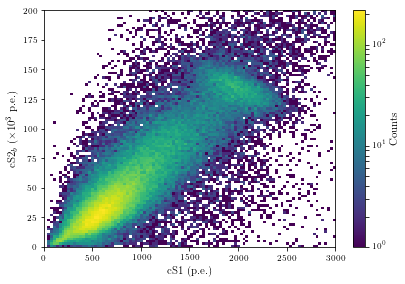

In [85]:
x.plot_cs1cs2b(bins=100, norm=LogNorm(), range=((0, 3e3), (0, 200e3)))
plt.colorbar(label='Counts')

sigmas_to_select = 1.5
energy_range = (m_ces.values['mu'] - sigmas_to_select * m_ces.values['sigma'], 
                m_ces.values['mu'] + sigmas_to_select * m_ces.values['sigma'])

g1, g2 = pickle.load(open('data/doke_sel2.pickle', 'rb'))
x_plot = np.linspace(0, 3e3, num = 100)

# Plot 1.5sigma lines
# for e in energy_range:
#     y_plot = g2 * (e / 13.7e-3 - x_plot / g1)
#     plt.plot(x_plot, y_plot, color='gray', ls='--', lw=1)
    
# Or plot the 662 line?
# for e in [662]:
#     y_plot = g2 * (e / 13.7e-3 - x_plot / g1)
#     plt.plot(x_plot, y_plot, color='red', ls='--', lw=1.5)
    
plt_divide_axis('y', 1e3)
plt.ylabel(r'cS2$_b$ ($\times10^3$ p.e.)')
plt.show()

e_ces in [616.1849166827819, 716.3810378596231) selection: 79074 rows removed (7.87% passed)


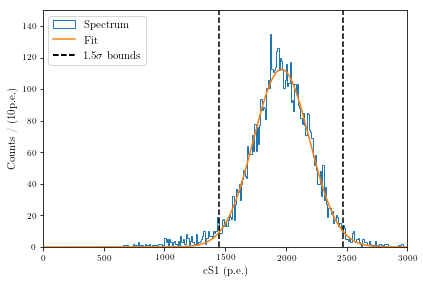

In [86]:
sigmas_to_select = 1.5
sigmas_to_select_cs1 = 1.5
    
# re-select energies
energy_range = (m_ces.values['mu'] - sigmas_to_select * m_ces.values['sigma'], 
                m_ces.values['mu'] + sigmas_to_select * m_ces.values['sigma'])
d = x.d
pp = cuts.range_selection(d, 'e_ces', energy_range)

popt_cs1_it0, _ , _ =  fit_gaus(pp['cs1'], (1200, 2500), 2000, 200, (0, 3000), 300, plot=False, print_level=0)
popt_cs1_it1, m_cs1_it1 , _ =  fit_gaus(pp['cs1'], (popt_cs1_it0[0] - sigmas_to_select_cs1 * popt_cs1_it0[1], 
                                     popt_cs1_it0[0] + sigmas_to_select_cs1 * popt_cs1_it0[1])
                         , popt_cs1_it0[0], popt_cs1_it0[1], (0, 3000), 300, print_level = 0, plot_guess=False)
plt.axvline(3200, ls='--', lw=2, color='black', label=r'1.5$\sigma$ bounds')
plt.xlabel('cS1 (p.e.)')
plt.ylabel('Counts')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[_i] for _i in [2,0,1]],[labels[_i] for _i in [2,0,1]])
plt.xlim(0, 3e3)
plt.ylim(0, 150)
plt.ylabel('Counts / (\si{10}{p.e.})')
plt_savefig('cs_s1_fit')

e_ces in [616.1849166827819, 716.3810378596231) selection: 79074 rows removed (7.87% passed)


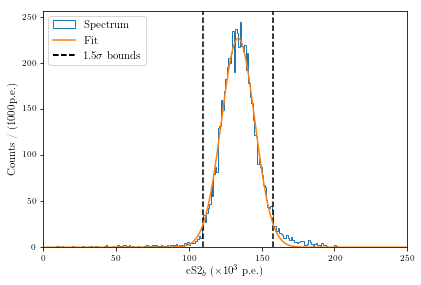

In [87]:
sigmas_to_select = 1.5
sigmas_to_select_cs2 =1.5
# re-select energies
energy_range = (m_ces.values['mu'] - sigmas_to_select * m_ces.values['sigma'], 
                m_ces.values['mu'] + sigmas_to_select * m_ces.values['sigma'])
d = x.d
pp = cuts.range_selection(d, 'e_ces', energy_range)

popt_cs2_it0, _ , _ =  fit_gaus(pp['cs2b'],  (100e3, 160e3), 120e3, 20e3, (0, 250e3), 250, int_step=10
                                , plot=False, print_level=0)
popt_cs2_it1, m_cs2_it1 , _ =  fit_gaus(pp['cs2b'], (popt_cs2_it0[0] - sigmas_to_select_cs2 * popt_cs2_it0[1], 
                                     popt_cs2_it0[0] + sigmas_to_select_cs2 * popt_cs2_it0[1])
                         , popt_cs2_it0[0], popt_cs2_it0[1], 
                                        (0, 250e3), 250, int_step=10, print_level = 0, plot_guess=False)
plt.axvline(300e3, ls='--', lw=2, color='black', label=r'1.5$\sigma$ bounds')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[_i] for _i in [2,0,1]],[labels[_i] for _i in [2,0,1]], loc='upper left')
plt_divide_axis('x', 1000)
plt.xlabel(r'cS2$_b$ ($\times 10^3$ p.e.)')
plt.xlim(0, 250e3)
plt.ylabel(r'Counts / (\si{1000}{p.e.})')
plt_savefig('cs_s2_fit')

In [88]:
#photopeak S1 selection
sigmas_to_select_cs1 = 2.5

popt_cs1_it0, _ , _ =  fit_gaus(pp['cs1'], (1200, 2500), 2000, 200, (0, 3000), 300, plot=False, print_level=0)
pp = cuts.range_selection(pp, 'cs1', (popt_cs1_it0[0] - sigmas_to_select_cs1 * popt_cs1_it0[1], 
                                             popt_cs1_it0[0] + sigmas_to_select_cs1 * popt_cs1_it0[1]))

cs1 in [1103.4145833800842, 2812.977218533545) selection: 113 rows removed (98.33% passed)


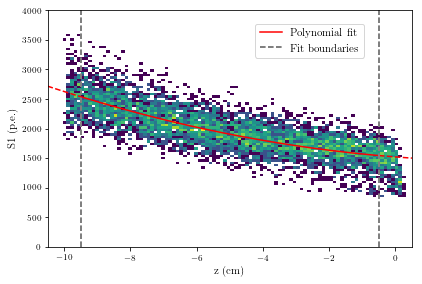

In [89]:
plt.hist2d(pp['z'], pp['s1'], bins=100, range=((-10.5, 0.5), (0, 4000)), norm=LogNorm())
fit_range = (-9.5, -0.5)

# Load and plot fit
x_before = np.linspace(-10.5, -9.5, 20)
x_plot = np.linspace(*fit_range, num=200)
x_after = np.linspace(-0.5, 0.5, 20)
popt_s1_ly, _ = pickle.load(open('data/cs137_ly_p2_sel2.pickle', 'rb'))
plt.plot(x_plot, p2(x_plot, *popt_s1_ly), color='red', label='Polynomial fit')
for _x_list in [x_before, x_after]:
    plt.plot(_x_list, p2(_x_list, *popt_s1_ly), color='red', ls='--')



for _l in fit_range:
    plt.axvline(_l, color='gray', ls='--', lw=2, label='Fit boundaries')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], loc=(0.57, 0.8))
#plt.legend([handles[_i] for _i in [2,0,1]],[labels[_i] for _i in [2,0,1]], loc='upper left')
    
plt.xlabel(r'z (\si{cm})')
plt.ylabel('S1 (p.e.)')
plt_savefig('cs_s1_ly')
plt.show()

e_ces in [616.1849166827819, 716.3810378596231) selection: 79074 rows removed (7.87% passed)
s2_bot in [89567.91215399749, 168778.57881881978) selection: 160 rows removed (97.63% passed)
Lifetime: 810.7 +- 43.3 us


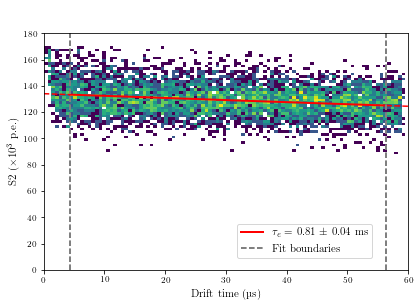

In [90]:
# Select in CES space
sigmas_to_select = 1.5
sigmas_to_select_cs2 = 2.5

energy_range = (m_ces.values['mu'] - sigmas_to_select * m_ces.values['sigma'], 
                m_ces.values['mu'] + sigmas_to_select * m_ces.values['sigma'])
d = x.d
pp = cuts.range_selection(d, 'e_ces', energy_range)

# Refine selection in s2 bot
popt_cs2_it0, _ , _ =  fit_gaus(pp['s2_bot'],  (100e3, 160e3), 120e3, 20e3, (0, 250e3), 300, int_step=10
                                , plot=False, print_level=0)
pp = cuts.range_selection(pp, 's2_bot', (popt_cs2_it0[0] - sigmas_to_select_cs2 * popt_cs2_it0[1], 
                                             popt_cs2_it0[0] + sigmas_to_select_cs2 * popt_cs2_it0[1]))

plt.hist2d(pp['drift_time'], pp['s2_bot'], bins=100, range=((0, 60), (0, 200e3)), norm=LogNorm())
fit_range = np.array((0.5, 9.5)) * (59.3-1.5) / 10 + 1.5

popt_s2_life, pcov_s2_life = pickle.load(open('data/cs137_electron_lifetime_sel2.pickle', 'rb'))
print('Lifetime: %.1f +- %.1f us' % (popt_s2_life[1], np.sqrt(np.diag(pcov_s2_life))[1]))
# pickle.dump((popt_s2_life, pcov_s2_life), open('data/cs137_electron_lifetime_sel%d.pickle' % iteration_number, 'wb'))

x_before = np.linspace(0, fit_range[0], 20)
x_plot = np.linspace(*fit_range, num=200)
x_after = np.linspace(fit_range[1], 60)

plt.plot(x_plot, exp_decay(x_plot, *popt_s2_life), color='red', lw=2,
         label = r'$\tau_e = $ %.2f $\pm$ %.2f ms' %(0.001 * popt_s2_life[1], 0.001 *np.sqrt(np.diag(pcov_s2_life))[1]))
for _x_list in [x_before, x_after]:
    plt.plot(_x_list, exp_decay(_x_list, *popt_s2_life), color='red', ls='--')


for _l in fit_range:
    plt.axvline(_l, color='gray', ls='--', lw=2, label='Fit boundaries')
handles, labels = plt.gca().get_legend_handles_labels()
plt.ylim(0, 180e3)
plt.legend(handles[:2], labels[:2], loc=(0.53, 0.05))
plt.xlabel(r'Drift time (\si{\micro s})')
plt_divide_axis('y', 1e3)
plt.ylabel(r'S2 ($\times 10^3$ p.e.)')
plt_savefig('cs_s2_elife')
plt.show()